# **NYC School Cafeteria Violations Analysis**


## **Overview**
This project provides a concise analysis of cafeteria violations in **public and private schools**, aiming to compare the quantity and nature of violations across different neighborhoods.  
By identifying areas with the greatest potential risk to public health, we uncover key insights, including:
- Distribution of violation types
- Prevalence of critical violations
- Geographic trends of infractions

The analysis underscores the **need for increased oversight and regulations** in specific high-risk areas to enhance **public health and food safety** in school cafeterias.

---

## **Data Understanding**
The dataset, provided by the **Department of Health and Mental Hygiene (DOHMH)**, includes current inspection data for school cafeterias in New York City. It covers public and private schools, which must adhere to strict food safety regulations.  

**Key points about the dataset:**
- Cafeterias are inspected at least annually to ensure compliance.
- The data includes information from the permitting process and inspection results over the past three years.
- It contains **7,662 recorded violations**, of which:
  - **2,125 are classified as critical**, meaning they pose a **substantial public health risk**.

⚠️ **Limitations of the dataset:**  
- Not suitable for historical comparisons, as it excludes ceased operations.
- May change due to adjudication for private, for-profit schools.

## **Methodology**
This analysis leverages data preprocessing, exploratory data analysis (EDA), and visualization using:

- **Python (`Pandas`, `Matplotlib`, `Seaborn`)** for data cleaning and visualization.
- **SQL** for querying and aggregating violations data.
- **Tableau** for interactive dashboards and deeper insights.

---





### Imports

In [4]:
import pandas as pd
import numpy as np
import sqlite3 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

Matplotlib is building the font cache; this may take a moment.


## Data Cleaning

#### Displaying all the Columns

In [3]:
pd.set_option('display.max_columns', None)

#### Importing Data

In [5]:
df = pd.read_csv('../data/DOHMH_School_Cafeteria_inspections__2020_-_Present_.csv')
df.head()

,Record ID,SchoolName,Number,Street,City,State,Borough,ZipCode,LastInspection,Permittee,InspectionDate,PTET,Site Type,Level,Code,ViolationDescription,LATITUDE,LONGITUDE,COMMUNITYBOARD,COUNCILDISTRICT,CENSUSTRACT,BIN,BBL,NTA,BOROCODE
0,40542839,"P.S. 127 MCKINLEY PARK, RALPH A. FABRIZIO SCHO...",7805,7 AVENUE,Brooklyn,NY,Brooklyn,11228.0,02/02/2023,NEW YORK CITY DEPARTMENT OF EDUCATION,07/28/2022,2530,FSE (Public School Cafeteria),NaN,NaN,NaN,40.624125,-74.018826,310.0,43.0,20600.0,3150481.0,3059730001,BK30,3
1,40736086,BAIS YITZHAK SCHOOL,141315,45 STREET,BROOKLYN,NY,Brooklyn,NaN,02/15/2023,CONGREGATION KHAL CHASIDEI SKWERE - BAIS YITZA...,03/01/2022,2533,FSE (Private School Cafeteria - Not-For-Profit),G,10A,Toilet facility not maintained and provided wi...,0.000000,0.000000,NaN,NaN,NaN,NaN,3,NaN,3
2,40542116,P.S. 135 SHELDON A. BROOKNER,684,LINDEN BOULEVARD,Brooklyn,NY,Brooklyn,11203.0,01/23/2023,NEW YORK CITY DEPARTMENT OF EDUCATION,11/17/2022,2530,FSE (Public School Cafeteria),C,04A,Food Protection Certificate (FPC) not held by ...,40.653633,-73.933114,317.0,41.0,87000.0,3102005.0,3046730001,BK91,3
3,40542900,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONR...,1300,BOYNTON AVENUE,Bronx,NY,Bronx,10472.0,03/09/2023,NEW YORK CITY DEPARTMENT OF EDUCATION,03/09/2023,2530,FSE (Public School Cafeteria),C,04L,Evidence of mice or live mice in establishment...,40.831594,-73.878911,209.0,18.0,5600.0,2027459.0,2038640001,BX08,2
4,40541560,"PS811M @ PS 149M, SUCCESS ACADEMY CHARTER-HARL...",34,WEST 118 STREET,New York,NY,Manhattan,10026.0,01/31/2023,NEW YORK CITY DEPARTMENT OF EDUCATION,08/01/2022,2530,FSE (Public School Cafeteria),C,04M,Live roaches in facility's food or non-food area.,40.802464,-73.946715,110.0,9.0,19000.0,1051434.0,1016010001,MN11,1


<em>Displaying the first few rows of the data to understand its structure.<em/>

#### Data Information

In [6]:
#info of our data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11093 entries, 0 to 11092
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Record ID             11093 non-null  object 
 1   SchoolName            11093 non-null  object 
 2   Number                11093 non-null  object 
 3   Street                11093 non-null  object 
 4   City                  10657 non-null  object 
 5   State                 11093 non-null  object 
 6   Borough               11093 non-null  object 
 7   ZipCode               10942 non-null  float64
 8   LastInspection        11093 non-null  object 
 9   Permittee             11093 non-null  object 
 10  InspectionDate        11093 non-null  object 
 11  PTET                  11093 non-null  int64  
 12  Site Type             11093 non-null  object 
 13  Level                 7974 non-null   object 
 14  Code                  7974 non-null   object 
 15  ViolationDescriptio

<em>The dataset contains 11,093 rows and 25 columns.<em/>

#### Dropping Unneeded Columns

In [7]:

columns_to_drop = ['Permittee',
       'PTET', 'COMMUNITYBOARD', 'COUNCILDISTRICT',
    'BIN', 'BBL', 'BOROCODE']

df.drop(columns_to_drop, axis=1, inplace=True)

<em>Dropped columns that do not contribute to the analysis.<em/>

#### Dropping Null Values

In [8]:
df['NTA'].dropna(inplace=True)

<em>Removing rows with null values in the 'NTA' column to ensure data consistency.<em/>

#### Grouping Violations by Date and Institution

In [9]:
df['Inspection event'] = df.apply(lambda row: str(row['Record ID']) + '_' + str(row['InspectionDate']), axis=1)

<em>Created an 'Inspection event' column to uniquely identify each inspection by combining 'Record ID' and 'InspectionDate'.<em/>

#### Renaming Columns

In [10]:
df.rename(columns={'NTA': 'NTA Code'}, inplace=True)

In [11]:
# Types of schools
count_unique = df.groupby('Site Type')['Record ID'].nunique()
count_unique

Site Type
FSE (Private School Cafeteria - For Profit)         155
FSE (Private School Cafeteria - Not-For-Profit)     473
FSE (Private School Cafeteria)                      105
FSE (Public School Cafeteria)                      1414
Name: Record ID, dtype: int64

<em>Renamed 'NTA' to 'NTA Code' for clarity.<em/>

### Schools Data Organizing

In [12]:
count_unique = df.groupby('Site Type')['Record ID'].nunique()
count_unique

Site Type
FSE (Private School Cafeteria - For Profit)         155
FSE (Private School Cafeteria - Not-For-Profit)     473
FSE (Private School Cafeteria)                      105
FSE (Public School Cafeteria)                      1414
Name: Record ID, dtype: int64

<em>Identified four target categories of schools. For analysis, these are aggregated into two main categories: Private and Public.<em/>

#### Grouping Schools

In [13]:
df['School Type'] = df['Site Type'].apply(lambda x: 'Public' if 'Public' in str(x) else 'Private')

<em>Grouped school types into 'Public' and 'Private'.<em/>

#### Handling Null Values in Violation Descriptions

In [14]:
# Null values in Violation description indicate that no violation was found per data description.
df['ViolationDescription'] =  df['ViolationDescription'].apply(lambda x: 'no violation' if pd.isna(x) else x)

<em>Replaced null values in 'ViolationDescription' with 'no violation'.<em/>

#### Importing demographics information.

In [15]:
nta_demographics_df = pd.read_excel('../data/Demographics_by_NTA.xlsx')
nta_demographics_df.info()
nta_demographics_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 8 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Neighborhood Tabulation Area (NTA) Name  193 non-null    object 
 1   NTA Code                                 189 non-null    object 
 2   populatio                                193 non-null    int64  
 3   Latino                                   193 non-null    float64
 4   % White                                  193 non-null    float64
 5   % African American                       193 non-null    float64
 6   % Asian                                  193 non-null    float64
 7   % Other                                  193 non-null    float64
dtypes: float64(5), int64(1), object(2)
memory usage: 12.2+ KB


,Neighborhood Tabulation Area (NTA) Name,NTA Code,populatio,Latino,% White,% African American,% Asian,% Other
0,Claremont-Bathgate,BX01,35560,60.6,1.0,37.3,0.1,0.010
1,Eastchester-Edenwald-Baychester,BX03,37887,24.6,3.1,66.0,4.2,0.022
2,Bedford Park-Fordham North,BX05,57685,75.0,4.2,15.6,3.8,0.015
3,Belmont,BX06,29115,61.0,18.2,16.3,2.1,0.024
4,Bronxdale,BX07,39423,54.9,13.9,26.1,2.9,0.022


<em>Examined demographic data to compare populations across different neighborhoods.<em/>

#### Cleaning Demographics Data

In [16]:
nta_demographics_df.dropna(inplace=True)
nta_demographics = nta_demographics_df.copy()[['Neighborhood Tabulation Area (NTA) Name','NTA Code','populatio']]
nta_demographics.rename(columns={'Neighborhood Tabulation Area (NTA) Name': 'NTA Name', 'populatio': 'NTA Population'}, inplace=True)

<em>Dropped nulls and filtered columns needed for merging.<em/>

#### Merging Dataframes

In [17]:
merged_df = df.merge(nta_demographics, on='NTA Code', how='inner')
merged_df['# of schools in NTA'] = merged_df.groupby('NTA Code')['Record ID'].transform('nunique')
merged_df.head(5)

,Record ID,SchoolName,Number,Street,City,State,Borough,ZipCode,LastInspection,InspectionDate,Site Type,Level,Code,ViolationDescription,LATITUDE,LONGITUDE,CENSUSTRACT,NTA Code,Inspection event,School Type,NTA Name,NTA Population,# of schools in NTA
0,40542839,"P.S. 127 MCKINLEY PARK, RALPH A. FABRIZIO SCHO...",7805,7 AVENUE,Brooklyn,NY,Brooklyn,11228.0,02/02/2023,07/28/2022,FSE (Public School Cafeteria),NaN,NaN,no violation,40.624125,-74.018826,20600.0,BK30,40542839_07/28/2022,Public,Dyker Heights,43888,9
1,40542116,P.S. 135 SHELDON A. BROOKNER,684,LINDEN BOULEVARD,Brooklyn,NY,Brooklyn,11203.0,01/23/2023,11/17/2022,FSE (Public School Cafeteria),C,04A,Food Protection Certificate (FPC) not held by ...,40.653633,-73.933114,87000.0,BK91,40542116_11/17/2022,Public,East Flatbush-Farragut,51922,14
2,40542900,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONR...,1300,BOYNTON AVENUE,Bronx,NY,Bronx,10472.0,03/09/2023,03/09/2023,FSE (Public School Cafeteria),C,04L,Evidence of mice or live mice in establishment...,40.831594,-73.878911,5600.0,BX08,40542900_03/09/2023,Public,West Farms-Bronx River,36014,6
3,40541560,"PS811M @ PS 149M, SUCCESS ACADEMY CHARTER-HARL...",34,WEST 118 STREET,New York,NY,Manhattan,10026.0,01/31/2023,08/01/2022,FSE (Public School Cafeteria),C,04M,Live roaches in facility's food or non-food area.,40.802464,-73.946715,19000.0,MN11,40541560_08/01/2022,Public,Central Harlem South,51064,16
4,40542147,"P.S. 244 RICHARD R. GREEN, BROOKLYN SCIENCE AN...",5400,TILDEN AVENUE,Brooklyn,NY,Brooklyn,11203.0,01/23/2023,07/19/2022,FSE (Public School Cafeteria),C,04L,Evidence of mice or live mice in establishment...,40.648413,-73.925977,94600.0,BK96,40542147_07/19/2022,Public,Rugby-Remsen Village,54666,14


<em>Merged the main dataset with demographics data and calculated the number of schools per NTA.<em/>

#### Creating Inspection Event Count Column

In [18]:
merged_df['InspectionEventCount'] = merged_df.groupby('Record ID')['Inspection event'].transform('count')

<em>Added a column to track how many times each school has been inspected.<em/>

#### Transforming Violation Descriptions to Lowercase

In [19]:
merged_df['ViolationDescription'] = merged_df['ViolationDescription'].str.lower()

<em>Normalized violation descriptions for consistent categorization.<em/>

#### Grouping Violations into Categories

<em>To simplify the analysis, a dictionary was created to categorize violations into broader groups for easier interpretation.<em/>

In [20]:
violations_labels_dict = {'Storage temperature': [
'Cold food item held above 41º F',
'Hot TCS food item not held at or above 140 °F',
'Cold TCS food item held above 41 °F',
'Hot food item not held at or above 140º F',
'hot tcs food item that has been cooked and  cooled is being held for service without first being reheated'],

'Food handling' : ['food not cooked to required minimum internal temperature',
'Food not protected from potential source of contamination',
'food is adulterated, contaminated',
'Food not cooled by an approved method',
'TCS food not cooled by an approved method',
'TCS food removed from cold holding',
'Thawing procedure improper',
'thawing procedures improper',
'contents are not suitable for human consumption',
'Unclean or cracked whole eggs',
'Raw food not properly washed',
'chemical or pesticide improperly stored',
'Food, supplies, and equipment not protected',
'Food, supplies, or equipment not protected',
'Canned food product observed swollen',
'Canned food product observed dented',
'damaged canned food to be returned to distributor not segregated'],

'Mice, rats, vermin': ['Mice',
'Rats',
'Live animal',
'Vermin'],

'Insects, pests': ['roaches',
'flies',
'insects',
'pests'],

'Facility': ['Plumbing not properly installed',
'Non-food contact surface improperly constructed',
'sewage disposal system',
'Sanitized equipment or utensil',
'Lighting Inadequate',
'Toilet facility not maintained',
'Toilet facility not provided',
'No facilities available to wash',
'Mechanical or natural ventilation not provided',
'mechanical or natural ventilation system not provided',
'facility not free from unsafe, hazardous, offensive or annoying condition',
'Bulb not shielded or shatterproof, in areas where there is extreme heat',
'contaminated by sewage or liquid waste',
'Failure to comply with an Order of the Board of Health',
'Lighting fixture',
'noxious gas or vapor detected'],

'Equipment issues':['Non-food contact surface or equipment',
'thermometer not provided',
'Single service item reused',
'Proper sanitization not provided',
'thermometer or thermocouple not provided',
'Food contact surface not properly washed',
'Food contact surface not properly maintained',
'Single service article reused or not protected',
'expanded polystyrene',
'maintenance of food contact surface improper',
'Cleaning and sanitizing of tableware, including dishes, utensils, and equipment deficient',
'Garbage receptacle not pest or water resistant'],

'General Hygiene': ['chemical improperly used',
'Hand washing facility not provided',
'Prohibited chemical used',
'No hand washing facility',
'Wiping cloths not stored clean',
'Wiping cloths soiled'],

'Personal Hygiene': ['worker does not wash hands thoroughly',
'eating, or drinking from open container in food preparation',
'vendor does not use utensil or other barrier to eliminate bare hand contact with food that will not receive adequate additional heat treatment',
'Personal cleanliness is inadequate',
'personal cleanliness inadequate'],

'Documents and Signs': ['Food protection certificate',
'Current valid permit',
'sign not posted',
'Establishment permit',
'Written Standard Operating Procedure',
'chemical improperly labeled',
'allergy information poster not conspicuously posted',
'acceptable manufacturer’s documentation not maintained on site',
'Document issued by the Board of Health',
'Permit not conspicuously displayed',
'nutritional information statement not posted',
'Food Protection Certificate']}


In [21]:
#transforming the dictionary to lower case 
lowercase_dict = {k: [v.lower() for v in values] for k, values in violations_labels_dict.items()}

#### Function to check if a violation description is contained in the dictionary values

In [22]:

def get_violation_label(description):
    if isinstance(description, float):
        return None  # Return None if the description is a float value
    for label, descriptions in lowercase_dict.items():
        if any(desc in description for desc in descriptions):
            return label
    return None

#### Applying the function to create a 'ViolationLabel' column

In [23]:
merged_df['ViolationLabel'] = merged_df['ViolationDescription'].apply(lambda x: get_violation_label(x))
print(merged_df['ViolationLabel'].value_counts())

ViolationLabel
Facility               2395
Equipment issues       1607
Mice, rats, vermin     1044
Documents and Signs     807
Insects, pests          783
Food handling           471
Storage temperature     284
General Hygiene         227
Personal Hygiene         44
Name: count, dtype: int64


*Created a new 'ViolationLabel' column to categorize violations based on the defined dictionary.*

#### Saving Cleaned Data to CSV

In [24]:
#Saving the cleaned and labeled DataFrame to a CSV file
merged_df.to_csv('../data/clean_data_labels.csv', index=False)

*I saved the dataframe containing all fo the cleaned data into a separate CSV file available in the data folder of this project's repository. This file was used for further visualization in Tableau.*

## Exploratory Dataset Analysis
EDA is conducted using Pandas, SQL and visualization using Seaborn and Matplotlib.

#### Comparison of Violations by Borough and School Type
This visualization provides a side-by-side comparison of total violations and critical violations (Level C) across boroughs, categorized by Public and Private schools. This comparison helps identify which boroughs and school types have higher proportions of critical violations.

The data is presented in absolute counts, without standardization, to reflect the real number of violations recorded per category.


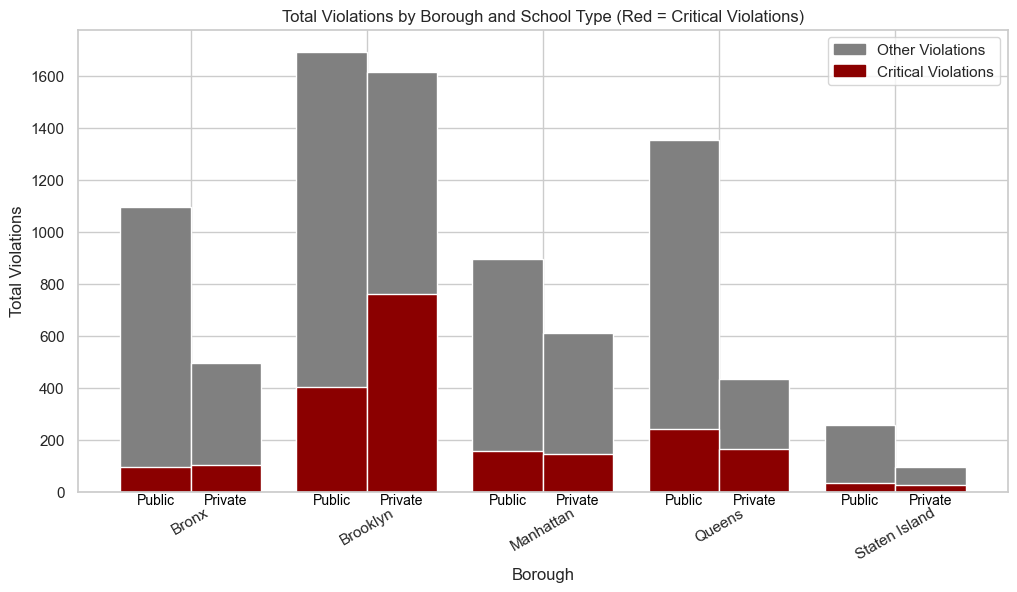

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate total violations per borough and school type
borough_school_counts = merged_df.groupby(["Borough", "School Type"]).size().unstack(fill_value=0)

# Calculate Level C violations per borough and school type
level_c_school_counts = merged_df[merged_df["Level"] == "C"].groupby(["Borough", "School Type"]).size().unstack(fill_value=0)

# Fill missing values with 0
borough_school_counts = borough_school_counts.fillna(0)
level_c_school_counts = level_c_school_counts.fillna(0)

# Convert to DataFrame for plotting
borough_school_df = borough_school_counts.copy()
borough_school_df["Public Critical Violations"] = level_c_school_counts.get("Public", 0)
borough_school_df["Private Critical Violations"] = level_c_school_counts.get("Private", 0)

# Reset index to keep "Borough" as a column
borough_school_df = borough_school_df.reset_index()

# Rename columns for clarity
borough_school_df = borough_school_df.rename(columns={"Public": "Public Total Violations", "Private": "Private Total Violations"})

# Set up the side-by-side bar chart
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.4  # Space bars slightly apart
boroughs = np.arange(len(borough_school_df["Borough"]))

# Plot total violations (gray for other violations)
bars1 = ax.bar(boroughs - bar_width/2, 
       borough_school_df["Public Total Violations"] - borough_school_df["Public Critical Violations"], 
       width=bar_width, color="gray")

bars2 = ax.bar(boroughs + bar_width/2, 
       borough_school_df["Private Total Violations"] - borough_school_df["Private Critical Violations"], 
       width=bar_width, color="gray")

# Overlay Critical Violations (red)
bars3 = ax.bar(boroughs - bar_width/2, borough_school_df["Public Critical Violations"], width=bar_width, color="darkred")
bars4 = ax.bar(boroughs + bar_width/2, borough_school_df["Private Critical Violations"], width=bar_width, color="darkred")

# Add labels **underneath** the bars to differentiate Public and Private
for borough, x_pos in zip(borough_school_df["Borough"], boroughs):
    ax.text(x_pos - bar_width/2, -50, "Public", ha="center", fontsize=10, color="black", transform=ax.transData)
    ax.text(x_pos + bar_width/2, -50, "Private", ha="center", fontsize=10, color="black", transform=ax.transData)

# Final touches
ax.set_xticks(boroughs)
ax.set_xticklabels(borough_school_df["Borough"], rotation=30)
plt.title("Total Violations by Borough and School Type (Red = Critical Violations)")
plt.xlabel("Borough")
plt.ylabel("Total Violations")

# Update legend to show only two categories: Critical Violations and Other Violations
handles = [
    plt.Rectangle((0,0),1,1, color="gray", label="Other Violations"),
    plt.Rectangle((0,0),1,1, color="darkred", label="Critical Violations")
]

plt.legend(handles=handles)
plt.show()


#### SQLite Database Integration

In [22]:
# Instantiating SQLite connection and database 
conn = sqlite3.Connection("data.sqlite")
db_path = '../data/school_database.db'  # Name of your SQLite database file
connection = sqlite3.connect(db_path)
table_name = 'schools'  # Table name                                                                                                                                    
merged_df.to_sql(table_name, connection, if_exists='replace', index=False) 
connection.commit()

*Integrated the cleaned data into an SQLite database for advanced querying.*

#### Number of Private and Public Schools

In [26]:
#How many private and public schools are in our data?

query = """
SELECT `School Type`, COUNT(DISTINCT `Record ID`) count
FROM schools
GROUP BY `School Type`;
"""
pd.read_sql(query, connection)

,School Type,count
0,Private,710
1,Public,1358


#### Average Number of Violations per School

In [27]:
round(len(merged_df[merged_df['Level'].notna()])/len(merged_df['Record ID'].unique()), 2)

3.71

#### Total Count of Violations by Level

In [28]:
query = """
SELECT Level, COUNT(*) as ViolationCount
FROM schools
GROUP BY Level
ORDER BY ViolationCount DESC;
"""
pd.read_sql(query, connection)

,Level,ViolationCount
0,G,4738
1,None,3003
2,C,2125
3,AV,472
4,CH,186
5,CP,58
6,A,57
7,NV,26


#### Unique Critical and General Violations

In [29]:
# Number of unique critical and general violations

query = """
SELECT
(SELECT COUNT(DISTINCT ViolationDescription) 
FROM schools) as TotalViolations,
(SELECT COUNT(DISTINCT ViolationDescription)
FROM schools
WHERE Level = 'C') as CriticalViolations,
(SELECT COUNT(DISTINCT ViolationDescription) 
FROM schools
WHERE Level = 'G') as GeneralViolations
;
"""
pd.read_sql(query, connection)

,TotalViolations,CriticalViolations,GeneralViolations
0,98,37,29


#### Number of Violations by School Type

In [30]:
query = """
SELECT 
       "School Type", 
       COUNT(*) as ViolationsCount
FROM schools
WHERE ViolationDescription != 'no violation'
GROUP BY "School Type"
ORDER BY ViolationsCount DESC;
"""
pd.read_sql(query, connection)


,School Type,ViolationsCount
0,Public,3848
1,Private,3814


#### Distribution of Critical and General Violations per School Type

In [31]:
query = """
SELECT
    `School Type`,
    COUNT(ViolationDescription) as TotalViolations,
    COUNT(CASE WHEN Level = 'C' THEN ViolationDescription ELSE NULL END) as CriticalViolations,
    COUNT(CASE WHEN Level = 'G' THEN ViolationDescription ELSE NULL END) as GeneralViolations

FROM schools 
WHERE ViolationDescription != 'no violation'
GROUP BY `School Type`



ORDER BY `School Type`;

"""

pd.read_sql(query, connection)

,School Type,TotalViolations,CriticalViolations,GeneralViolations
0,Private,3814,1199,2041
1,Public,3848,926,2697


#### Ratio of Critical and General Violations to All Violations by School Type

In [32]:
query = """
SELECT
    `School Type`,
    ROUND(CAST(COUNT(CASE WHEN Level = 'C' THEN ViolationDescription ELSE NULL END) AS FLOAT) / (COUNT(*)), 2) as CriticalViolationsRatio,
    ROUND(CAST(COUNT(CASE WHEN Level = 'G' THEN ViolationDescription ELSE NULL END) AS FLOAT) / COUNT(*), 2) as GeneralViolationsRatio

FROM 

schools
WHERE ViolationDescription != 'no violation'

GROUP BY `School Type`
ORDER BY `School Type`;

"""

pd.read_sql(query, connection)

,School Type,CriticalViolationsRatio,GeneralViolationsRatio
0,Private,0.31,0.54
1,Public,0.24,0.70


#### Average Number of Violations per School by School Type

In [33]:
query = """
SELECT
    `School Type`,
    
    ROUND(CAST(COUNT(CASE WHEN Level = 'C' THEN ViolationDescription ELSE NULL END) AS FLOAT) /
    COUNT(DISTINCT "Record ID"), 2) as avg_critical,

    ROUND(CAST(COUNT(CASE WHEN Level = 'G' THEN ViolationDescription ELSE NULL END) AS FLOAT)/ 
    COUNT(DISTINCT "Record ID"), 2) as avg_general
FROM schools
WHERE Level != 'no violation'
GROUP BY `School Type`
ORDER BY `School Type`

;
"""

pd.read_sql(query, connection)



,School Type,avg_critical,avg_general
0,Private,1.93,3.29
1,Public,0.84,2.45


#### Top 10 Critical Violation Categories

In [34]:
query = """
SELECT DISTINCT ViolationLabel, COUNT(*) AS Count
FROM schools
WHERE Level = 'G'
GROUP BY ViolationLabel
ORDER BY Count DESC
;
"""
pd.read_sql(query, connection)

,ViolationLabel,Count
0,Facility,2222
1,Equipment issues,1309
2,"Insects, pests",476
3,"Mice, rats, vermin",353
4,Food handling,172
5,General Hygiene,121
6,Documents and Signs,85


#### Top 10 Critical Violations types

In [35]:
query = """
SELECT ViolationDescription, COUNT(*) cnt_violations
FROM schools
WHERE Level = 'C'
GROUP BY ViolationDescription
ORDER BY cnt_violations DESC
LIMIT 10
;
"""
pd.read_sql(query, connection)

,ViolationDescription,cnt_violations
0,evidence of mice or live mice in establishment...,393
1,evidence of mice or live mice present in facil...,288
2,food protection certificate not held by superv...,206
3,"food contact surface not properly washed, rins...",151
4,food protection certificate (fpc) not held by ...,145
5,filth flies or food/refuse/sewage associated w...,129
6,"food, supplies, and equipment not protected fr...",111
7,food not protected from potential source of co...,104
8,cold food item held above 41º f (smoked fish a...,98
9,filth flies or food/refuse/sewage-associated (...,76


#### What critical cafeteria violations categories are most common?

In [36]:
query = """
SELECT DISTINCT ViolationLabel, COUNT(*) AS Count
FROM schools
WHERE Level = 'C'
GROUP BY ViolationLabel
ORDER BY Count DESC
;
"""
pd.read_sql(query, connection)

,ViolationLabel,Count
0,"Mice, rats, vermin",691
1,Documents and Signs,352
2,"Insects, pests",307
3,Food handling,263
4,Equipment issues,247
5,Storage temperature,138
6,General Hygiene,54
7,Personal Hygiene,42
8,Facility,31


#### Comparison of NYC Boroughs by Number of Violations per School

In [37]:
query = """
SELECT Borough, COUNT(*) AS "Violations count"
FROM schools
WHERE Level != 'no violation'

GROUP BY Borough
ORDER BY "Violations count" DESC
LIMIT 5
;
"""
pd.read_sql(query, connection)

,Borough,Violations count
0,Brooklyn,3781
1,Queens,1560
2,Manhattan,1159
3,Bronx,931
4,Staten Island,231


#### Average # of violations per school by Borough

In [38]:
query = """
SELECT
    Borough,
    ROUND(CAST(COUNT(ViolationDescription) AS FLOAT) /
    COUNT(DISTINCT "Record ID"), 1) as "Average violations",
    COUNT(DISTINCT "Record ID") as "Number of Schools"

FROM schools
WHERE ViolationDescription != 'no violation'
GROUP BY Borough
ORDER BY "Average violations" DESC

;
"""

pd.read_sql(query, connection)



,Borough,Average violations,Number of Schools
0,Brooklyn,6.0,635
1,Queens,3.9,400
2,Manhattan,3.7,312
3,Bronx,3.1,297
4,Staten Island,2.9,79


  - *“Calculating the average number of violations school in different boroughs allows for an easy comparison of regulatory compliance across different regions.”*


#### Number of Critical Violations per School by Neighborhood

In [39]:
query = """
SELECT "NTA Name", COUNT(*) AS "Critical violations"
FROM schools
WHERE "Level" = 'C'
GROUP BY "NTA Name"
ORDER BY "Critical violations" DESC
LIMIT 10;
"""
pd.read_sql(query, connection)

,NTA Name,Critical violations
0,Borough Park,250
1,Williamsburg,80
2,Bedford,61
3,Far Rockaway-Bayswater,43
4,Bensonhurst West,42
5,Flatbush,38
6,Canarsie,38
7,Prospect Lefferts Gardens-Wingate,34
8,Crown Heights South,34
9,Hudson Yards-Chelsea-Flatiron-Union Square,32


#### Average Number of Critical Violations per School by Neighborhood

In [40]:
query = """
SELECT 
    "NTA Name", 
    COUNT(*) / COUNT(DISTINCT "Record ID") AS "Avg Critical Violations per School"
FROM schools
WHERE "Level" = 'C' AND ViolationLabel != 'No Violation'
GROUP BY "NTA Name"
ORDER BY "Avg Critical Violations per School" DESC
LIMIT 5;

"""
pd.read_sql(query, connection)

,NTA Name,Avg Critical Violations per School
0,Kew Gardens,5
1,New Dorp-Midland Beach,4
2,Borough Park,4
3,park-cemetery-etc-Brooklyn,3
4,Williamsburg,3


#### Ranking Neighborhoods by Population and Mice-Related Critical Violations

In [41]:
query = """
SELECT 
    "NTA Name",
    COUNT(*) AS "Critical violations",
    RANK() OVER (ORDER BY "NTA Population" DESC) AS "Population Rank",
    "NTA Population"
FROM schools
WHERE "Level" = 'C' AND ViolationLabel = 'Mice, rats, vermin'
GROUP BY "NTA Name"
ORDER BY "Critical violations" DESC
LIMIT 5;

"""
pd.read_sql(query, connection)



,NTA Name,Critical violations,Population Rank,NTA Population
0,Borough Park,78,4,102494
1,Williamsburg,26,98,34373
2,Rugby-Remsen Village,16,47,54666
3,Canarsie,15,9,88522
4,Bedford,15,17,77847


#### Examining Mice and Vermin Violations

In [42]:
# We focused on violations related to mice and vermin, as these represent critical health risks. 
# The SQL query below was used to rank neighborhoods by these specific violations:

query = """
SELECT 
    "NTA Name", 
    COUNT(*) AS "Mice, rats, vermin violations"
FROM schools
WHERE ViolationLabel = 'Mice, rats, vermin'
GROUP BY "NTA Name"
ORDER BY "Mice, rats, vermin violations" DESC
LIMIT 10;

"""
pd.read_sql(query, connection)


,NTA Name,"Mice, rats, vermin violations"
0,Borough Park,133
1,Williamsburg,50
2,Bedford,30
3,Canarsie,23
4,Rugby-Remsen Village,22
5,Flatbush,21
6,East New York,20
7,Sunset Park West,19
8,Crown Heights South,19
9,Bushwick South,19


  - *These results highlight neighborhoods with the highest incidence of mice-related violations, suggesting areas that may require targeted pest control measures.*

#### Mice Violations in Borough Park

In [46]:
# Number of mice-related violations for each school in the Borough Park.
query = """
SELECT 
    SchoolName,
    COUNT(*) AS "Mice violations count"
FROM schools
WHERE ViolationLabel = 'Mice, rats, vermin' AND "NTA Name" = 'Borough Park'
GROUP BY SchoolName
ORDER BY "Mice violations count" DESC
LIMIT 5
;

"""
pd.read_sql(query, connection)

,SchoolName,Mice violations count
0,YESHIVA TIFERETH ELIMELECH,9
1,BOBOVER YESHIVA BNEI ZION,9
2,TALMUD TORAH IMREI CHAIM,8
3,BAIS TZIPORAH SCHOOL,8
4,MOSDOS CHASIDEI SQUARE,7


*Completed the exploratory analysis for school cafeteria violations, focusing on critical violations and geographic distribution.*
______________________
<p>With the basic exploratory analysis complete, we can delve into more complex SQL queries to draw deeper insights.


### Advanced SQL Query Context Additions
To showcase more complex SQL skills, this section highlights advanced techniques such as subqueries, CTEs, and window functions for deeper analysis.


#### Using CTEs for Analysis

**CTE Explanation**:
   - *Common Table Expressions (CTEs) simplify complex aggregations by breaking queries into manageable parts, especially helpful for multi-step queries where intermediary results are needed.* <br>

**Window Function Clarification**:
   - *The `RANK()` function provides a ranked order of neighborhoods based on violations, enabling clear identification of priority areas for intervention.*

In [47]:
query = """
WITH ViolationCounts AS (
    SELECT
        `NTA Name`,
        COUNT(*) AS `Total Violations`
    FROM schools
    WHERE Level != 'no violation'
    GROUP BY `NTA Name`
)
SELECT
    `NTA Name`,
    `Total Violations`,
    RANK() OVER (ORDER BY `Total Violations` DESC) AS `Violation Rank`
FROM ViolationCounts
LIMIT 10;
"""

pd.read_sql(query, connection)

,NTA Name,Total Violations,Violation Rank
0,Borough Park,743,1
1,Williamsburg,243,2
2,Bedford,193,3
3,Far Rockaway-Bayswater,126,4
4,Canarsie,118,5
5,Bensonhurst West,117,6
6,Midwood,113,7
7,Stuyvesant Heights,107,8
8,Crown Heights North,106,9
9,Crown Heights South,105,10


*This query uses a Common Table Expression (CTE) to create a temporary result set (`ViolationCounts`) that lists the total number of violations for each neighborhood. It then ranks these neighborhoods by the number of violations.* 
__________________________________

#### Applying CTEs to Analyze Specific Violations in Borough Park ####


In [37]:
query = """
WITH BoroughParkViolations AS (
    SELECT 
        "School Type",
        ViolationLabel,
        COUNT(*) AS ViolationCount
    FROM schools
    WHERE 
        "NTA Name" = 'Borough Park'
        AND (ViolationDescription != 'no violation')
    GROUP BY "School Type", ViolationLabel
)

SELECT 
    "School Type",
    SUM(CASE WHEN ViolationLabel = 'Mice, rats, vermin' THEN ViolationCount ELSE 0 END) AS MiceVerminViolations,
    SUM(ViolationCount) AS TotalViolations
FROM BoroughParkViolations
GROUP BY "School Type";

"""

pd.read_sql(query, connection)

,School Type,MiceVerminViolations,TotalViolations
0,Private,121,674
1,Public,12,69


*This query uses a CTE to filter for true violations in Borough Park, comparing mice/vermin-specific and total health violations between private and public schools for a clear side-by-side view of compliance levels.*
_________________

#### Combining Subqueries for Detailed Comparisons

**Subquery Insight**:
   - *Subqueries allow for cross-referencing and more detailed comparisons within a single query. This showcases the ability to integrate multiple layers of data for comprehensive insights.*

In [51]:
query = """
SELECT
    `School Type`,
    (SELECT COUNT(*) FROM schools WHERE `School Type` = s.`School Type` AND Level = 'C') AS `Critical Violations`,
    (SELECT COUNT(*) FROM schools WHERE `School Type` = s.`School Type` AND Level = 'G') AS `General Violations`
FROM schools s
GROUP BY `School Type`
ORDER BY `Critical Violations` DESC;
"""

pd.read_sql(query, connection)

,School Type,Critical Violations,General Violations
0,Private,1199,2041
1,Public,926,2697


*Explanation*: This query uses subqueries to calculate the number of critical and general violations for each school type.
___________________________________________________________


#### Enhanced Filtering with Conditional Logic

**Conditional Logic Clarification**:
   - *Using CASE statements in SQL allows for row-level conditional operations, providing flexibility to create custom counts or classifications within a query. This approach helps in identifying specific data trends, such as isolating counts of particular violation types.* <br>


In [59]:
query = """
SELECT
    `NTA Name`,
    SUM(CASE WHEN ViolationLabel = 'Mice, rats, vermin' THEN 1 ELSE 0 END) AS `Mice Violations`,
    SUM(CASE WHEN ViolationLabel = 'Food handling' THEN 1 ELSE 0 END) AS `Food Handling Violations`
FROM schools
GROUP BY `NTA Name`
ORDER BY `Mice Violations` DESC
LIMIT 5;
"""

pd.read_sql(query, connection)

,NTA Name,Mice Violations,Food Handling Violations
0,Borough Park,133,70
1,Williamsburg,50,18
2,Bedford,30,14
3,Canarsie,23,11
4,Rugby-Remsen Village,22,5


*Explanation*: By applying CASE statements, we can highlight which neighborhoods face the most significant issues related to specific violations, guiding targeted actions and resource allocation.
_________________

#### Analyzing Compliance Disparities by School Type in Borough Park with focus on Mice/Vermin violations.

In [67]:
query = """
WITH BoroughParkMiceVerminViolations AS (
    SELECT 
        "School Type",
        COUNT(*) AS "Mice Vermin Violations by School Type"
    FROM schools
    WHERE 
        "NTA Name" = 'Borough Park'
        AND "ViolationDescription" != 'no violation'
        AND ViolationLabel = 'Mice, rats, vermin'
    GROUP BY "School Type"
),
TotalMiceVerminViolations AS (
    SELECT 
        SUM("Mice Vermin Violations by School Type") AS "Total Mice Vermin Violations in Borough Park"
    FROM BoroughParkMiceVerminViolations
)
SELECT 
    bp."School Type",
    bp."Mice Vermin Violations by School Type",
    tbp."Total Mice Vermin Violations in Borough Park",
    ROUND((bp."Mice Vermin Violations by School Type" * 100.0 / tbp."Total Mice Vermin Violations in Borough Park"), 2) AS "Percentage of All Mice Vermin Violations in Borrough Park"
FROM BoroughParkMiceVerminViolations bp
JOIN TotalMiceVerminViolations tbp ON 1=1;
"""

pd.read_sql_query(query, connection)


,School Type,Mice Vermin Violations by School Type,Total Mice Vermin Violations in Borough Park,Percentage of All Mice Vermin Violations in Borrough Park
0,Private,121,133,90.98
1,Public,12,133,9.02


#### Query Explanation

This query analyzes mice/vermin violations in Borough Park, breaking down the data by school type (public vs. private) to identify compliance disparities. The query uses Common Table Expressions (CTEs) to structure the analysis as follows:

1. **`BoroughParkViolations` CTE**:
   - Filters for all mice/vermin violations within Borough Park, excluding records labeled "no violation."
   - Counts the number of mice/vermin violations for each school type (public and private).

2. **`TotalBoroughParkViolations` CTE**:
   - Calculates the total number of mice/vermin violations across all schools in Borough Park, regardless of school type.
   
3. **Final Query**:
   - Joins the CTEs to produce a summary of violations by school type.
   - Calculates the percentage of total mice/vermin violations in Borough Park attributed to each school type, highlighting any significant disparities in compliance.

This structure provides a clear side-by-side view of mice/vermin violations, showing if one school type (e.g., private schools) is responsible for a disproportionately high number of violations.


---
## Takeaways for Key Results

The analysis reveals a stark difference in the distribution of mice/vermin-related violations in Borough Park, with **private schools responsible for 91% of all such violations** and **public schools accounting for only 9%**. This significant disparity highlights a few key insights and potential action points:

1. **Differences in Compliance Practices**: The higher rate of violations in private schools suggests there may be gaps in compliance practices, resources, or oversight compared to public schools. This finding indicates a need to examine private schools' sanitation and health standards more closely.

2. **Targeted Oversight and Inspections**: Given that nearly 9 out of 10 mice/vermin violations occur in private schools, targeted health inspections and stricter regulations could be implemented specifically for private institutions. Focused intervention here could substantially reduce health risks within Borough Park.

3. **Resource Allocation and Support**: The data suggests that private schools may require additional resources or support to address sanitation issues effectively. Policies or programs aimed at improving facilities and pest control in private schools could help close the gap in compliance.

In summary, these findings underscore the need for tailored public health policies that address compliance disparities. Ensuring that private schools meet the same standards as public schools could significantly improve the overall health and safety of school environments in Borough Park.
